# Power Demand Load History Preprocessing and EDA



This notebook performs comprehensive preprocessing and exploratory data analysis on power demand load history data. The dataset includes:

- Time-based features (date, year, month, day, weekday, hour)

- Power demand measurements

- Temperature readings



## Objective

Prepare the dataset for machine learning tasks, particularly load forecasting based on time and temperature features.

In [26]:
# Import required libraries

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

from datetime import datetime

from sklearn.preprocessing import MinMaxScaler



# Set random seed for reproducibility

np.random.seed(42)



# Configure matplotlib for better visualizations

plt.style.use('ggplot')

plt.rcParams['figure.figsize'] = [12, 6]

plt.rcParams['axes.grid'] = True

## Load Dataset and Initial Inspection

In [ ]:
# Load the dataset
from pathlib import Path

# Construct path to dataset
data_path = Path("../dataset/_PDB_Load_History.csv")

# Load data with error handling
try:
    df = pd.read_csv(data_path)
    print("Dataset Shape:", df.shape)
    print("\nFirst 10 rows:")
    display(df.head(10))
except FileNotFoundError:
    print(f"Error: Dataset not found at {data_path}")
except Exception as e:
    print(f"Error loading dataset: {str(e)}")

Dataset Shape: (103776, 8)

First 10 rows:


,date,year,month,day,weekday,hour,demand,temperature
0,3/1/2003,2003,3,1,7,1,12863.0,29
1,3/1/2003,2003,3,1,7,2,12389.0,28
2,3/1/2003,2003,3,1,7,3,12155.0,29
3,3/1/2003,2003,3,1,7,4,12072.0,27
4,3/1/2003,2003,3,1,7,5,12160.0,29
5,3/1/2003,2003,3,1,7,6,12568.0,28
6,3/1/2003,2003,3,1,7,7,13236.0,29
7,3/1/2003,2003,3,1,7,8,14190.0,29
8,3/1/2003,2003,3,1,7,9,15213.0,28
9,3/1/2003,2003,3,1,7,10,15647.0,27


## Data Type Conversion and Initial Checks

In [28]:
# Convert date to datetime

df['date'] = pd.to_datetime(df['date'])



# Create datetime column combining date and hour

df['datetime'] = df['date'] + pd.to_timedelta(df['hour'], unit='h')



# Check data types and null values

print("Data Types:")

print(df.info())



print("\nNull Values Count:")

print(df.isnull().sum())



print("\nSummary Statistics:")

print(df.describe(include='all'))

Data Types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103776 entries, 0 to 103775
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   date         103776 non-null  datetime64[ns]
 1   year         103776 non-null  int64         
 2   month        103776 non-null  int64         
 3   day          103776 non-null  int64         
 4   weekday      103776 non-null  int64         
 5   hour         103776 non-null  int64         
 6   demand       103776 non-null  float64       
 7   temperature  103776 non-null  int64         
 8   datetime     103776 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(6)
memory usage: 7.1 MB
None

Null Values Count:
date           0
year           0
month          0
day            0
weekday        0
hour           0
demand         0
temperature    0
datetime       0
dtype: int64

Summary Statistics:
                      date           year      

## Handle Missing Values and Sort Data

In [29]:
# Sort by datetime

df.sort_values('datetime', inplace=True)

# Set datetime as index for time-based interpolation

df.set_index('datetime', inplace=True)



# Handle missing values with interpolation for numeric columns

numeric_cols = ['demand', 'temperature']

df[numeric_cols] = df[numeric_cols].interpolate(method='time')

# Reset index to keep datetime as column

df.reset_index(inplace=True)



# Forward fill any remaining missing values

df.fillna(method='ffill', inplace=True)



# Remove duplicates

df.drop_duplicates(inplace=True)



print("After preprocessing:")

print("Shape:", df.shape)

print("\nRemaining null values:")

print(df.isnull().sum())

After preprocessing:
Shape: (103776, 9)

Remaining null values:
datetime       0
date           0
year           0
month          0
day            0
weekday        0
hour           0
demand         0
temperature    0
dtype: int64


C:\Users\Ritesh\AppData\Local\Temp\ipykernel_22692\1049368991.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


## Create Additional Time-Based Features

In [30]:
# Create is_weekend feature

df['is_weekend'] = df['date'].dt.weekday.isin([5, 6]).astype(int)



# Create season feature

def get_season(month):

    if month in [12, 1, 2]:

        return 0  # Winter

    elif month in [3, 4, 5]:

        return 1  # Spring

    elif month in [6, 7, 8]:

        return 2  # Summer

    else:

        return 3  # Autumn



df['season'] = df['month'].apply(get_season)



# Ensure weekday is numeric (0-6)

df['weekday'] = pd.to_numeric(df['weekday'])



print("Feature value counts:")

print("\nSeason distribution:")

print(df['season'].value_counts().sort_index())

print("\nWeekend distribution:")

print(df['is_weekend'].value_counts())

print("\nWeekday distribution:")

print(df['weekday'].value_counts().sort_index())

Feature value counts:

Season distribution:
season
0    24576
1    26496
2    26496
3    26208
Name: count, dtype: int64

Weekend distribution:
is_weekend
0    74112
1    29664
Name: count, dtype: int64

Weekday distribution:
weekday
1    14832
2    14832
3    14832
4    14832
5    14808
6    14808
7    14832
Name: count, dtype: int64


## Correlation Analysis and Visualization

In [ ]:
# Helper functions for visualization
def plot_correlation_matrix(df, columns):
    """Plot correlation matrix for given columns."""
    corr_matrix = df[columns].corr()
    
    plt.figure(figsize=(10, 8))
    im = plt.imshow(corr_matrix, cmap='coolwarm', aspect='auto')
    plt.colorbar(im)
    
    for i in range(len(corr_matrix)):
        for j in range(len(corr_matrix)):
            text = plt.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}',
                          ha='center', va='center', color='black')
    
    plt.xticks(range(len(corr_matrix)), corr_matrix.columns, rotation=45)
    plt.yticks(range(len(corr_matrix)), corr_matrix.columns)
    plt.title('Feature Correlations')
    plt.tight_layout()
    
    return corr_matrix

def plot_time_series(df, datetime_col, value_col, title, ylabel):
    """Plot time series data."""
    plt.figure(figsize=(15, 5))
    plt.plot(df[datetime_col], df[value_col])
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_scatter(df, x_col, y_col, title):
    """Create scatter plot."""
    plt.figure(figsize=(10, 6))
    plt.scatter(df[x_col], df[y_col], alpha=0.5)
    plt.title(title)
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.show()

def plot_boxplot_by_category(df, cat_col, val_col, cat_labels, title):
    """Create boxplot by category."""
    plt.figure(figsize=(10, 6))
    plt.boxplot([df[df[cat_col]==i][val_col] for i in range(len(cat_labels))],
                labels=cat_labels)
    plt.title(title)
    plt.ylabel(val_col)
    plt.show()

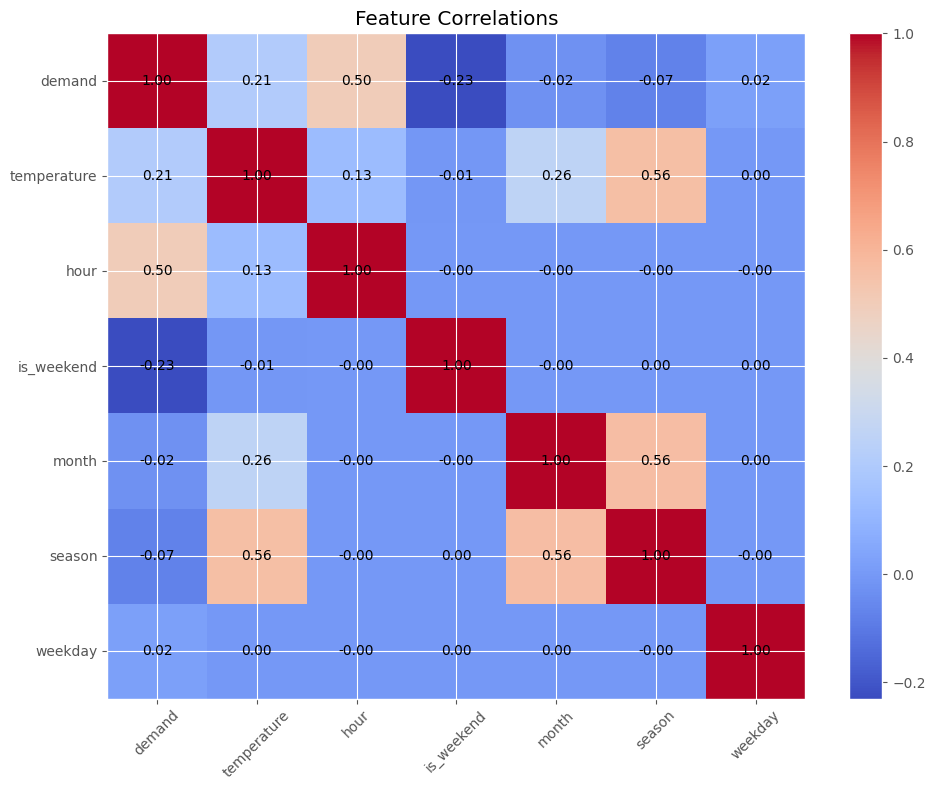


Correlations with demand:
demand         1.000000
hour           0.500231
temperature    0.208075
weekday        0.021199
month         -0.023170
season        -0.071366
is_weekend    -0.229613
Name: demand, dtype: float64


In [ ]:
# Calculate and plot correlations using helper function
cols_for_correlation = ['demand', 'temperature', 'hour', 'is_weekend', 'month', 'season', 'weekday']
corr_matrix = plot_correlation_matrix(df, cols_for_correlation)

# Print strongest correlations with demand
demand_corr = corr_matrix['demand'].sort_values(ascending=False)
print("\nCorrelations with demand:")
print(demand_corr)

## Time Series and Pattern Visualization

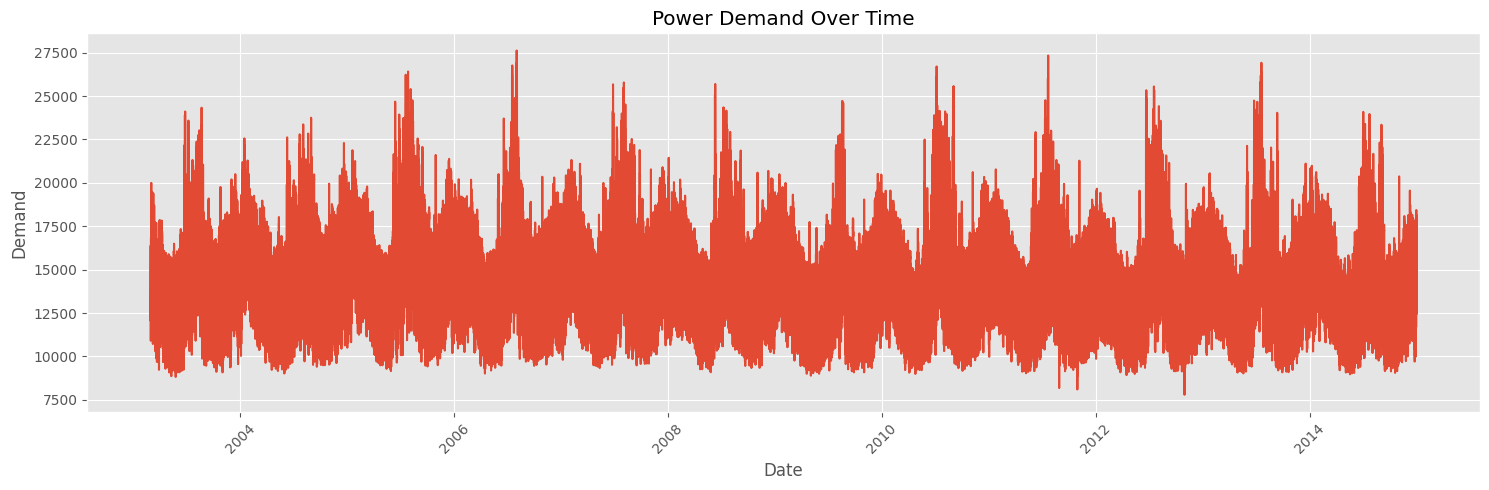

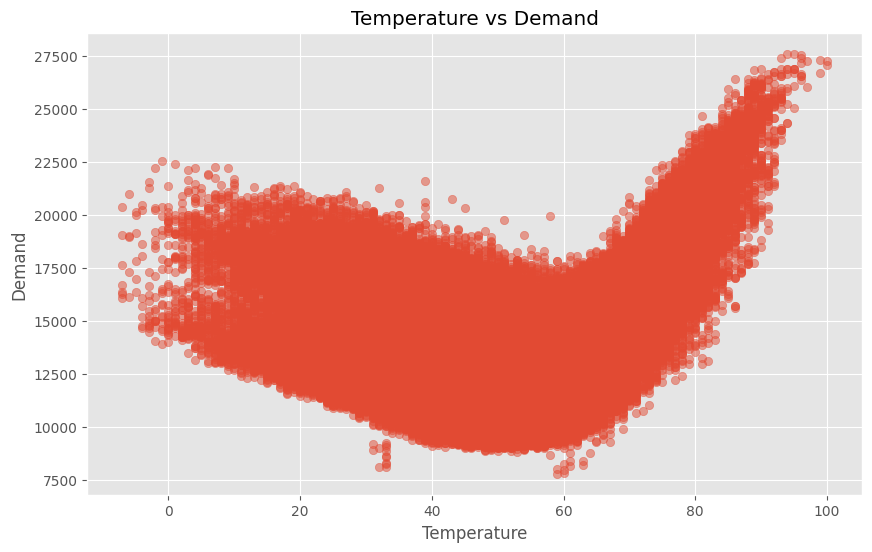

C:\Users\Ritesh\AppData\Local\Temp\ipykernel_22692\161567320.py:41: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df[df['weekday']==i]['demand'] for i in range(7)],


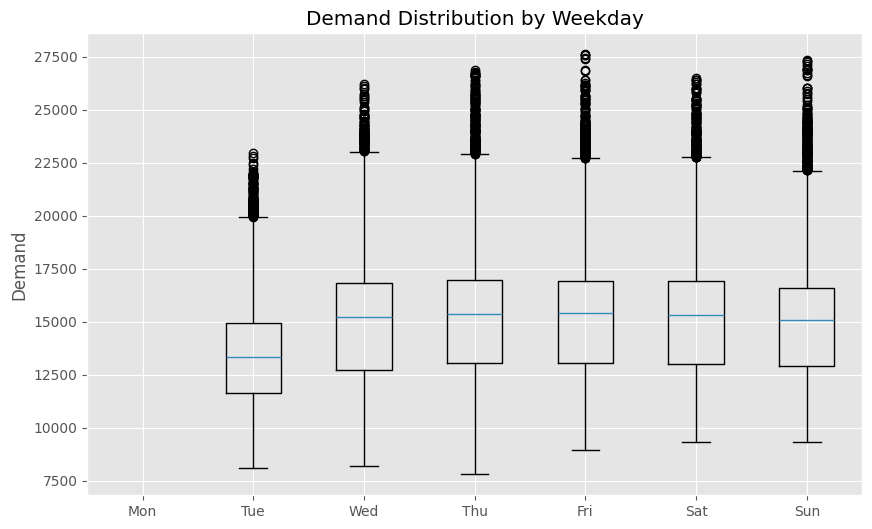

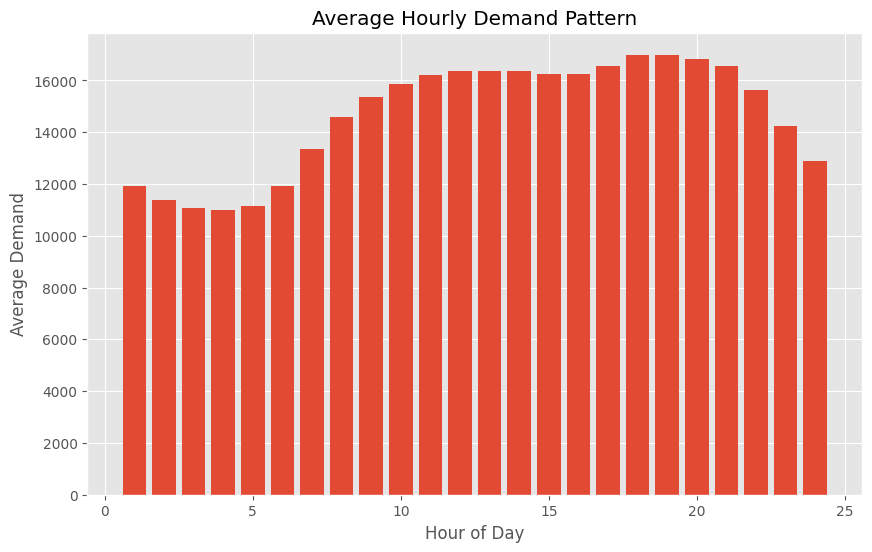

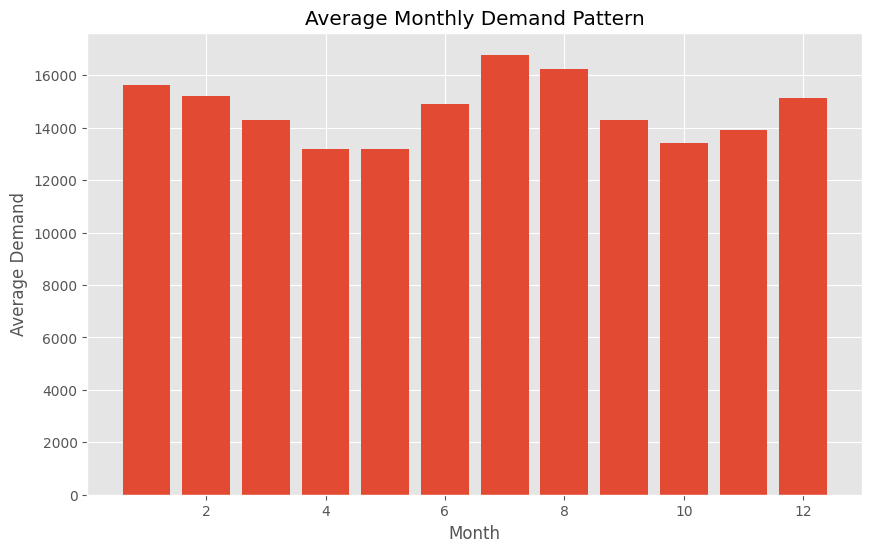

In [ ]:
# Create visualizations using helper functions
# 1. Line plot of demand over time
plot_time_series(df, 'datetime', 'demand', 'Power Demand Over Time', 'Demand')

# 2. Scatter plot of temperature vs demand
plot_scatter(df, 'temperature', 'demand', 'Temperature vs Demand')

# 3. Box plot of demand by weekday
plot_boxplot_by_category(df, 'weekday', 'demand', 
                        ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'],
                        'Demand Distribution by Weekday')

# 4. Average hourly demand pattern
hourly_demand = df.groupby('hour')['demand'].mean()
plt.figure(figsize=(10, 6))
plt.bar(hourly_demand.index, hourly_demand.values)
plt.title('Average Hourly Demand Pattern')
plt.xlabel('Hour of Day')
plt.ylabel('Average Demand')
plt.show()

# 5. Monthly demand patterns
monthly_demand = df.groupby('month')['demand'].mean()
plt.figure(figsize=(10, 6))
plt.bar(monthly_demand.index, monthly_demand.values)
plt.title('Average Monthly Demand Pattern')
plt.xlabel('Month')
plt.ylabel('Average Demand')
plt.show()

## Outlier Detection and Handling

Outlier Removal Summary:
Original rows: 103776
Rows after removing outliers: 102613
Removed outliers: 1163
Percentage removed: 1.12%


C:\Users\Ritesh\AppData\Local\Temp\ipykernel_22692\2452069230.py:63: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ax1.hist(df[~combined_mask]['demand'], bins=50, alpha=0.5, label='Outliers')
C:\Users\Ritesh\AppData\Local\Temp\ipykernel_22692\2452069230.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ax2.hist(df[~combined_mask]['temperature'], bins=50, alpha=0.5, label='Outliers')


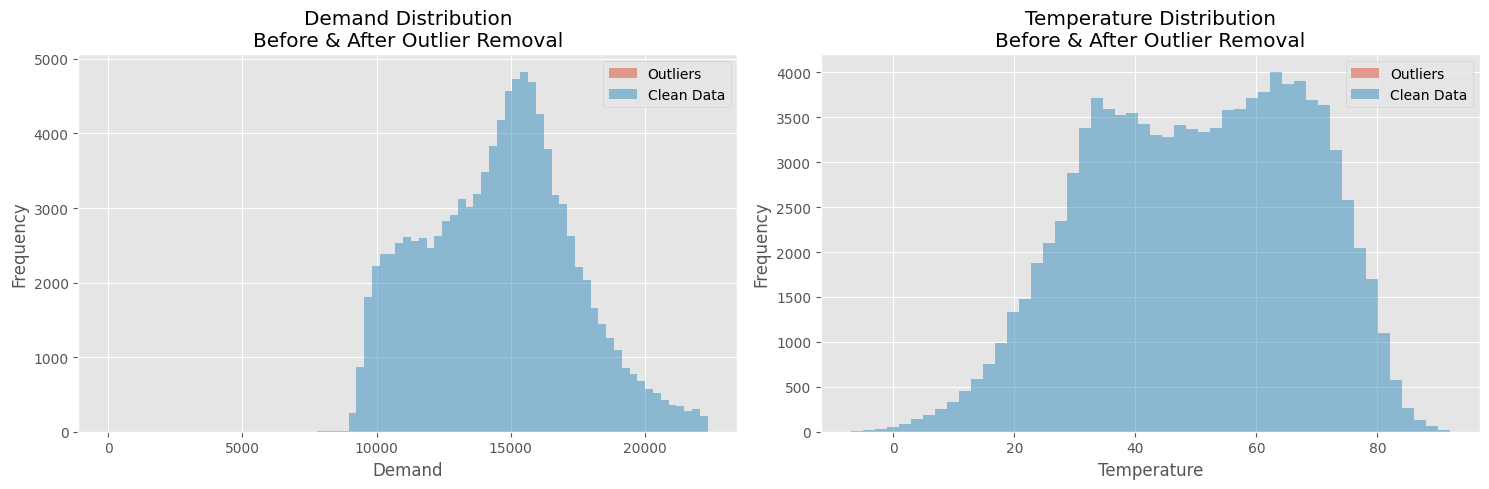

In [33]:
# Function to detect outliers using IQR method

def detect_outliers(df, column):

    Q1 = df[column].quantile(0.25)

    Q3 = df[column].quantile(0.75)

    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR

    upper_bound = Q3 + 1.5 * IQR

    return (df[column] >= lower_bound) & (df[column] <= upper_bound)



# Store original shape

original_shape = df.shape[0]



# Detect and remove outliers for demand and temperature

demand_mask = detect_outliers(df, 'demand')

temp_mask = detect_outliers(df, 'temperature')

combined_mask = demand_mask & temp_mask



# Remove outliers

df = df[combined_mask].copy()



# Print summary of removed rows

print("Outlier Removal Summary:")

print(f"Original rows: {original_shape}")

print(f"Rows after removing outliers: {df.shape[0]}")

print(f"Removed outliers: {original_shape - df.shape[0]}")

print(f"Percentage removed: {((original_shape - df.shape[0]) / original_shape * 100):.2f}%")



# Plot demand distribution before and after outlier removal

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))



# Before

ax1.hist(df[~combined_mask]['demand'], bins=50, alpha=0.5, label='Outliers')

ax1.hist(df['demand'], bins=50, alpha=0.5, label='Clean Data')

ax1.set_title('Demand Distribution\nBefore & After Outlier Removal')

ax1.set_xlabel('Demand')

ax1.set_ylabel('Frequency')

ax1.legend()



# Temperature

ax2.hist(df[~combined_mask]['temperature'], bins=50, alpha=0.5, label='Outliers')

ax2.hist(df['temperature'], bins=50, alpha=0.5, label='Clean Data')

ax2.set_title('Temperature Distribution\nBefore & After Outlier Removal')

ax2.set_xlabel('Temperature')

ax2.set_ylabel('Frequency')

ax2.legend()



plt.tight_layout()

plt.show()

## Feature Scaling and Train-Test Split

Train-Test Split Summary:
Training set shape: (82090, 11)
Testing set shape: (20523, 11)


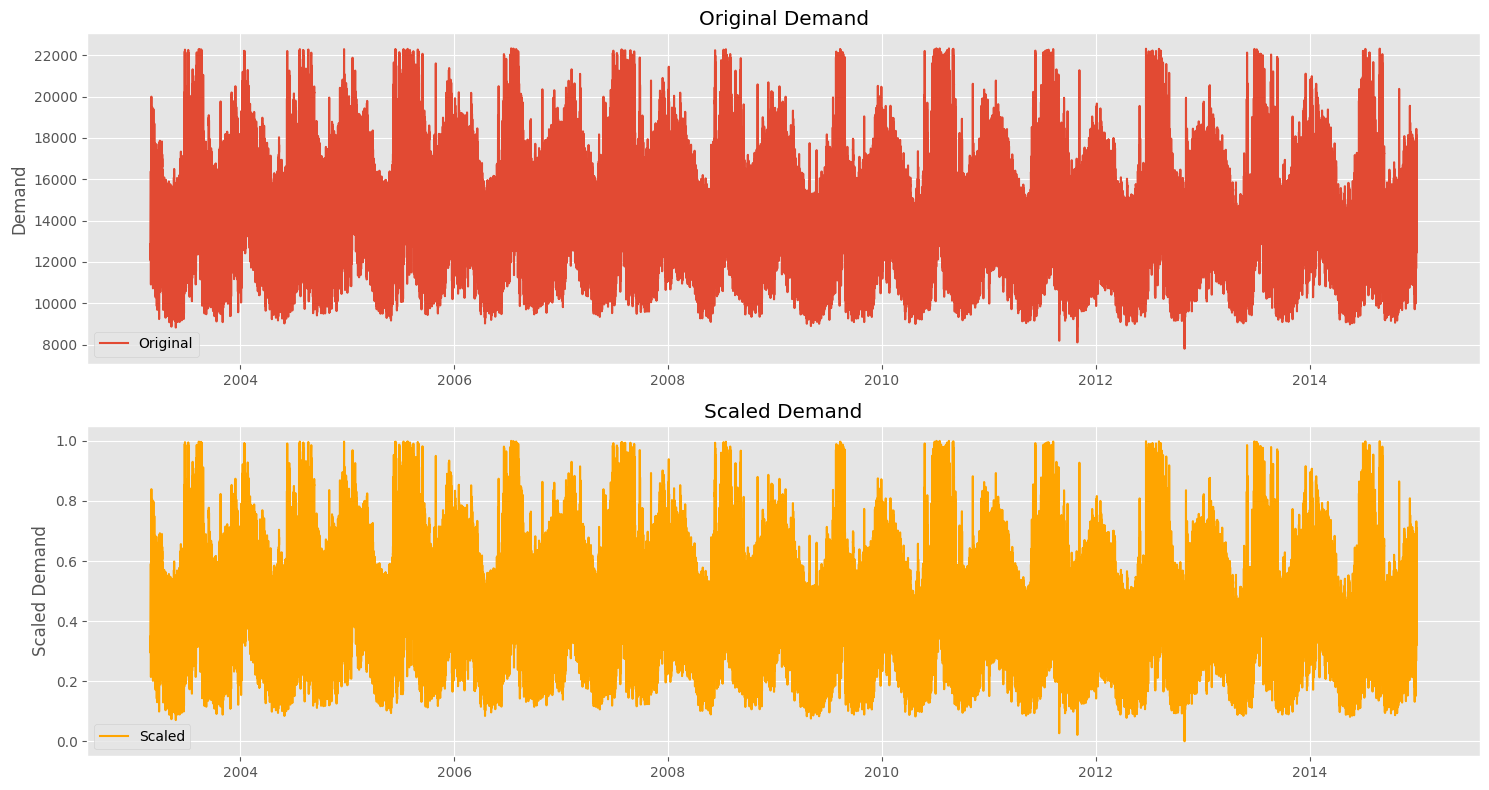

In [34]:
# Features to scale

features_to_scale = ['demand', 'temperature', 'hour']



# Initialize MinMaxScaler

scaler = MinMaxScaler()



# Scale features

df_scaled = df.copy()

df_scaled[features_to_scale] = scaler.fit_transform(df[features_to_scale])



# Split data into train and test (last 20% as test)

split_idx = int(len(df_scaled) * 0.8)

train = df_scaled.iloc[:split_idx]

test = df_scaled.iloc[split_idx:]



print("Train-Test Split Summary:")

print(f"Training set shape: {train.shape}")

print(f"Testing set shape: {test.shape}")



# Plot scaled vs unscaled demand

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))



ax1.plot(df['datetime'], df['demand'], label='Original')

ax1.set_title('Original Demand')

ax1.set_ylabel('Demand')

ax1.legend()



ax2.plot(df['datetime'], df_scaled['demand'], label='Scaled', color='orange')

ax2.set_title('Scaled Demand')

ax2.set_ylabel('Scaled Demand')

ax2.legend()



plt.tight_layout()

plt.show()

## Export Preprocessed Dataset

In [ ]:
# Create preprocessing summary with enhanced metadata
from datetime import datetime

preprocessing_summary = {
    'dataset_info': {
        'original_rows': original_shape,
        'final_rows': df_scaled.shape[0],
        'rows_removed_by_outliers': original_shape - df_scaled.shape[0],
        'features_count': len(df_scaled.columns),
        'date_range': {
            'start': df['datetime'].min().strftime('%Y-%m-%d'),
            'end': df['datetime'].max().strftime('%Y-%m-%d')
        }
    },
    'train_test_split': {
        'train_size': train.shape[0],
        'test_size': test.shape[0],
        'split_ratio': 0.8
    },
    'features': {
        'all_features': list(df_scaled.columns),
        'scaled_features': features_to_scale,
        'categorical_features': ['weekday', 'month', 'season', 'is_weekend'],
        'temporal_features': ['datetime', 'date', 'hour'],
        'target_variable': 'demand'
    },
    'preprocessing_steps': [
        'datetime_conversion',
        'missing_value_interpolation',
        'duplicate_removal',
        'outlier_removal_using_iqr',
        'feature_scaling_minmax'
    ],
    'metadata': {
        'created_at': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'python_version': platform.python_version(),
        'pandas_version': pd.__version__,
        'numpy_version': np.__version__,
        'sklearn_version': sklearn.__version__
    }
}

# Save preprocessing summary
import json
with open('preprocessing_summary.json', 'w') as f:
    json.dump(preprocessing_summary, f, indent=4)

# Save processed dataset
df_scaled.to_csv('processed_load_data.csv', index=False)

print("Files saved:")
print("1. processed_load_data.csv - Contains the fully preprocessed dataset")
print("2. preprocessing_summary.json - Contains preprocessing statistics and information")

# Display first few rows of final processed dataset
print("\nFirst few rows of processed dataset:")
display(df_scaled.head())

Files saved:
1. processed_load_data.csv - Contains the fully preprocessed dataset
2. preprocessing_summary.json - Contains preprocessing statistics and information

First few rows of processed dataset:


,datetime,date,year,month,day,weekday,hour,demand,temperature,is_weekend,season
0,2003-03-01 01:00:00,2003-03-01,2003,3,1,7,0.000000,0.348601,0.363636,1,1
1,2003-03-01 02:00:00,2003-03-01,2003,3,1,7,0.043478,0.316003,0.353535,1,1
2,2003-03-01 03:00:00,2003-03-01,2003,3,1,7,0.086957,0.299911,0.363636,1,1
3,2003-03-01 04:00:00,2003-03-01,2003,3,1,7,0.130435,0.294203,0.343434,1,1
4,2003-03-01 05:00:00,2003-03-01,2003,3,1,7,0.173913,0.300254,0.363636,1,1
